## Preprocessing

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import random

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Let's define the hyperparameters and complete the necessary preprocessing steps.

In [1]:
TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = 1
TIME_WINDOW_SIZE = 1 # Selected as one here, but the time steps will be added as lag features later. These lags will be 12 in total, ie the same time window size that exists in other demos.
EPOCHS = 200

NUMBER_OF_CLIENTS = 50 # Controls the number of households used for forecasting.

In [ ]:
def load_data():
    df = pd.read_csv('combined.csv', parse_dates=[1])
    return df

def basic_preprocess_fn(df:pd.DataFrame):
    """ Selects the electricity data with standard tariffs belonging to year 2013 and sorts the dataframe based on 
    DateTime column. """
    
    temp = df[df['DateTime'].dt.strftime('%Y') == '2013'].sort_values(by=['DateTime'])
    #temp = temp[temp['stdorToU'] == 'Std']
    #temp = temp.drop(axis=1, columns = 'stdorToU')
    return temp

def extract_clients(df:pd.DataFrame):
    """ Extracts client ids and client data from the given dataframe, which is assumed to hold multiple 
    client information."""
    
    client_keys = df['LCLid'].value_counts().keys().tolist()
    client_list = []

    for key in client_keys:
        client_df = df[df['LCLid'] == key]
        client_list.append(client_df)

    return client_keys, client_list

def resample_fn(df:pd.DataFrame):
    """ Resamples the time-series dataframe so that it reflects hourly electricity consumption values. It also does
    basic data processing such as dropping unnecessary columns. """
    
    resample_df = df.astype({"KWH/hh (per half hour) ": float}).drop(columns = ['LCLid']).set_index('DateTime').resample(rule='H').sum()
    resample_df.rename(columns = {'KWH/hh (per half hour) ':'kWh'}, inplace = True)
    return resample_df

def remove_bad_clients(client_keys:list, client_list:list):
    """ Drops the clients with datapoints fewer than 0.9 percent of the client with highest amount of data. """
    
    sizes = [len(e) for e in client_list]
    biggest_client = max(sizes) 
    ratios = [size/biggest_client for size in sizes]
    indices_to_keep = [idx for idx,e in enumerate(ratios) if e>=0.9]
    
    client_keys_selected = [client_keys[index] for index in indices_to_keep]
    client_list_selected = [client_list[index] for index in indices_to_keep]
    
    return client_keys_selected, client_list_selected

def create_client_dict(client_keys, client_data_list):
    """ Matches every client ID with its own electricty consumption data and returns the pairs in a python dictionary. """
    client_dict = {}
    for key, df in zip(client_keys, client_data_list):
        client_dict[key] = df
        
    return client_dict

def remove_anomalies(df_list):
  """Function that removes kwh values that are smaller than 0.5 and bigger than 2.5. 
  Written to see if removing these somewhat abnormal values would increase the forecasting performance. """
  df_list_new = []
  for df in df_list:
    new_df = df[ (df['kWh'] >= 0.5) & (df['kWh'] <= 2.5) ]
    df_list_new.append(new_df)
  return df_list_new

In [ ]:
df = load_data()
temp = basic_preprocess_fn(df)
client_keys, client_list = extract_clients(temp)
client_list_resampled = list(map(resample_fn, client_list))
client_keys_selected, client_list_selected = remove_bad_clients(client_keys, client_list_resampled)

client_list_selected_new = remove_anomalies(client_list_selected)
client_list_selected_new = [e for e in client_list_selected_new if len(e)>=5000]

client_dict = create_client_dict(client_keys_selected, client_list_selected_new)

We can now sample some households(clients) from all the available ones.

In [ ]:
random.seed(10)
shortlist_keys = random.sample(list(client_dict.keys()), 8)
shortlist_keys

['MAC001302',
 'MAC002172',
 'MAC002170',
 'MAC004463',
 'MAC001845',
 'MAC001816',
 'MAC001819',
 'MAC001367']

In [ ]:
sadi_df_list = []
sadi_key_list = []
for k, v in client_dict.items():
  if k in shortlist_keys:
    print('Added the dataset of household:', k)
    sadi_key_list.append(k)
    sadi_df_list.append(v[:4380])

Added the dataset of household: MAC001302
Added the dataset of household: MAC001816
Added the dataset of household: MAC001367
Added the dataset of household: MAC002170
Added the dataset of household: MAC004463
Added the dataset of household: MAC002172
Added the dataset of household: MAC001819
Added the dataset of household: MAC001845


In [ ]:
for e in sadi_df_list:
  print(e.shape)

(4380, 1)
(4380, 1)
(4380, 1)
(4380, 1)
(4380, 1)
(4380, 1)
(4380, 1)
(4380, 1)


The cells below are about the simple feature engineering methods I tried while writing the thesis. Unfortunately none of those helped to increase the forecasting results much, so I ignored using the functions below for this demo. Feel free to play with those if you want to observe the effects of adding potentially helpful features.

The only difference will be the introduction of lag features. I used them just to see if adding time steps as explicit features will make a difference in comparison with the window function provided by tensorflow. Expectedly, the results did not change much.

In [ ]:
def create_lags(df, col_name, num_lags):
  """ Adds lag features from the given column."""
  for lag in range(1, num_lags):
    df[col_name + '_lag_' + str(lag)] = df[col_name].shift(lag)
    
  return df

def add_date_features(df):
  """ Creates features based on the datetime index of the measurement data. """
  #df['hour'] = df.index.hour
  #df['day_of_week'] = df.index.dayofweek
  #df['week_of_year'] = df.index.isocalendar().week
  df['month'] = df.index.month
  df['is_winter'] = df['month'].isin([1, 2]).astype(int)
  df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
  df['is_summer'] = df['month'].isin([6, 7]).astype(int)

  return df

In [ ]:
pd.options.mode.chained_assignment = None
enriched_data = []

for e in sadi_df_list:
  temp = e.copy()
  temp = create_lags(temp, 'kWh', 12)
  #temp = pd.concat([temp, weather], join='inner', axis = 1)
  #temp = create_lags(temp, 'temperature', TIME_WINDOW_SIZE)
  #temp = create_lags(temp, 'humidity', TIME_WINDOW_SIZE)
  #temp = add_date_features(temp)
  #temp = temp.drop('month', axis=1)
  #temp = pd.concat([temp, uv], join='inner', axis = 1)
  temp['target'] = temp['kWh'].shift(-1)
  temp = temp.iloc[11:temp.shape[0]-1]
  temp = temp.fillna(value = 0)
  

  enriched_data.append(temp)

target_col_number = len(enriched_data[0].columns)-1

## Creating the Client Class

We will now define the client class and its attributes. Remember that distributed ML refers to the setting where all clients are disconnected from each other and they train for one round, which is immediately followed by testing the trained model. No weight sharing happens as in the case of Federated Learning.

In [ ]:
class Client:
    def __init__(self, cid, data, round_id = None):
    
        self.cid = cid
        self.df = data
        self.round_id = round_id
        self.train_loss_hist   = []
        self.val_loss_hist     = []
        self.predictions_hist  = []
        self.test_metrics_hist = []
        self.test_metrics_pct_hist = []
        self.weights_hist = []
        
    def create_model(self):
        """ Initialize an LSTM model."""
        self.model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, dropout=0.1, batch_input_shape=(None,TIME_WINDOW_SIZE,target_col_number), return_sequences=True),
        tf.keras.layers.LSTM(16, dropout=0.1),
        tf.keras.layers.Dense(1),
        ])
        return self.model
    
    def train_test_val_split(self):
        """ Splits the client data into train, test and validation datasets. """

        df_size = self.df.shape[0]

        self.train = self.df.iloc[:int(df_size * 0.7)]
        self.val = self.df.iloc[int(df_size * 0.7):int(df_size * 0.9)]
        self.test = self.df.iloc[int(df_size * 0.9):]

        return self.train, self.val, self.test
    
    def normalize_fn(self, scaler = MinMaxScaler()):
        """ Normalizes the input arrays with the given scaler. Train array is taken as the reference. """

        self.train_sc = scaler.fit_transform( self.train.values )
        self.val_sc = scaler.transform( self.val.values )
        self.test_sc = scaler.transform( self.test.values )
        self.scaler = scaler
        
        return self.train_sc, self.val_sc, self.test_sc, self.scaler
    
    def create_tensor_datasets(self):
        """ Applies the window function on the scaled train,test and validation arrays. Output will be tf.data datasets."""
        
        def window_fn(input_array, window_size=TIME_WINDOW_SIZE, batch_size=TRAIN_BATCH_SIZE):
            """ Creates time series windows for the given input array and returns them as a batch of tensorflow dataset."""
            dataset = tf.data.Dataset.from_tensor_slices(input_array)
            dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
            dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
            dataset = dataset.map(lambda window: (window[:-1, :target_col_number], window[:-1, target_col_number][0]))
            dataset = dataset.batch(batch_size).prefetch(1)

            return dataset
    
        self.train_tf = window_fn(self.train_sc, window_size = TIME_WINDOW_SIZE)
        self.val_tf = window_fn(self.val_sc, window_size = TIME_WINDOW_SIZE)
        self.test_tf = window_fn(self.test_sc, window_size = TIME_WINDOW_SIZE, batch_size=TRAIN_BATCH_SIZE)
        
        return self.train_tf, self.val_tf, self.test_tf
        
    def train_fn(self, lr = 0.002, opt = tf.keras.optimizers.Adam, epochs = EPOCHS):
        """ Fits the model on train&validation data and returns the corresponding MSE loss values. """
        model = self.model
        train = self.train_tf
        validation = self.val_tf
        
        learning_rate = lr
        optimizer = opt(learning_rate = lr)
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=optimizer,
                  metrics=["mse"])

        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        history = model.fit(x=train, epochs=epochs, validation_data=validation, callbacks=[callback], verbose=False)
        self.train_loss = history.history['loss']
        self.val_loss = history.history['val_loss']

        self.train_loss_hist.append(self.train_loss)
        self.val_loss_hist.append(self.val_loss)
        return self.train_loss, self.val_loss
    
    def evaluate(self):
        """ Evaluate the trained local model on local test set, return predicstions and test MSE."""
        #new_model = tf.keras.models.Sequential([
        #tf.keras.layers.LSTM(32, dropout=0.1, batch_input_shape = (1,12,1), return_sequences=True),
        #tf.keras.layers.LSTM(16, dropout=0.1),
        #tf.keras.layers.Dense(1),
        #])
        
        #new_model.set_weights(self.model.get_weights())

        forecast = pd.DataFrame(self.model.predict(self.test_tf), columns=['target'])
        residue = pd.DataFrame(self.test_sc, columns = self.df.columns).iloc[TIME_WINDOW_SIZE: , :target_col_number].reset_index(drop=True)
        final_df = pd.concat([residue, forecast], join='inner', axis = 1)
        predictions = self.scaler.inverse_transform(final_df)
        self.pred_df = pd.DataFrame(data = predictions, columns = list(self.df.columns.values))
        self.test_metrics = round(mean_squared_error(self.test.iloc[TIME_WINDOW_SIZE: , target_col_number], self.pred_df.iloc[: , target_col_number]), 5)
        #self.test_metrics_pct = mean_absolute_percentage_error(self.test[12:], self.predictions)

        self.predictions_hist.append(predictions)
        self.test_metrics_hist.append(self.test_metrics)
        #self.test_metrics_pct_hist.append(self.test_metrics_pct)
        return self.pred_df, self.test_metrics
    
    def set_weights(self, avg_weights):
        """ Set the model weights taken from the server."""
        return self.model.set_weights(avg_weights)
    
    def send_weights(self):
        """ Send the local model's weights to server. """
        weights = np.array(self.model.get_weights(), dtype=object)

        #self.weights_hist.append(weights)
        return weights

## Experiments

We can now instantiate a client object for every household and store those objects in a list. Those client objects are all instantiated with their corresponding dataset and household ID. Their remaining attributes will then be populated as training progresses.

In addition to that, we have to create a server class for coordinating federated training with simple FedAVG.

In [ ]:
def instantiate_clients(client_dict):
    """ Takes a dictionary of client, client_data pairs and returns a list of client objects. """
    
    client_objects = []
    for client, data in client_dict.items():
        instance = Client(cid = client, data = data.iloc[:4380]) # Changed to a subset of data for fast experimentation.
        client_objects.append(instance)
    return client_objects

class Server:
    def __init__(self, number_of_training_rounds):
    
        self.rounds = number_of_training_rounds
        self.current_rnd = 0
        
    def federated_training(self, client_instances):
        """ Helper function to orchestrate the model training in clients."""
    
        def initialize_clients():
            for cl in client_instances:
                cl.create_model()
                cl.train_test_val_split()
                cl.normalize_fn()
                cl.create_tensor_datasets()
            return
            
        def train_and_evaluate():
            
            for i in tf.range(self.rounds):
                print('-'*50)
                print('Round', self.current_rnd, 'is starting...')
                """ Block that checks the current round and sets the mean weights to all clients before training process."""
                if self.current_rnd != 0:
                    avg = average_weights()
                    for cl in client_instances:
                        cl.set_weights(avg)
                
                """ Block for training the model on clients, getting their weights and appending them to the server's 
                weight list to be used with FedAVG algorithm. """
                self.weights_list = []
                for cl in client_instances:
                    cl.train_fn()
                    cl.evaluate()
                    
                    #if cl.round_id == None:
                    #    cl.round_id = 1
                    #else:
                    #    cl.round_id += 1
                        
                    cl_w = cl.send_weights()
                    self.weights_list.append(cl_w)
                    print(cl.cid, 'completed training')

                self.current_rnd += 1
            return
    
        def average_weights():
            weights_avg = np.mean( np.array(self.weights_list), axis = 0)
            return weights_avg
    
        initialize_clients()
        train_and_evaluate()
        
        return

In [ ]:
client_dict = {}

for k, df in zip(sadi_key_list, enriched_data):
  client_dict[k] = df

For shorter experimentation times, feel free to uncomment the lines below and use the "client_object_short" for federated training. Also, the number of training rounds can be changed to any other desired value, I used 9 for the sake of getting the results quickly.

In [ ]:
client_objects = instantiate_clients(client_dict)
#random.seed(10)
#client_objects_short = random.sample(client_objects, 6)

In [ ]:
server = Server(number_of_training_rounds = 9)

In [ ]:
server.federated_training(client_objects)

--------------------------------------------------
Round 0 is starting...
MAC001302 completed training
MAC001816 completed training
MAC001367 completed training
MAC002170 completed training
MAC004463 completed training
MAC002172 completed training
MAC001819 completed training
MAC001845 completed training
--------------------------------------------------
Round 1 is starting...
MAC001302 completed training
MAC001816 completed training
MAC001367 completed training
MAC002170 completed training
MAC004463 completed training
MAC002172 completed training
MAC001819 completed training
MAC001845 completed training
--------------------------------------------------
Round 2 is starting...
MAC001302 completed training
MAC001816 completed training
MAC001367 completed training
MAC002170 completed training
MAC004463 completed training
MAC002172 completed training
MAC001819 completed training
MAC001845 completed training
--------------------------------------------------
Round 3 is starting...
MAC00130

## Test MSE Scores

The results of the training can be seen below for every client, in addition to average MSE score over all clients.

In [ ]:
test_mses = []
#test_mapes = []
ids = []
for cl in client_objects:
  ids.append(cl.cid)
  test_mses.append(cl.test_metrics)
  #test_mapes.append(cl.test_metrics_pct)

print('Average test MSE over all clients:', round(np.mean(test_mses), 3))
#print('Average test MAPE over all clients:', round(np.mean(test_mapes), 3))

Average test MSE over all clients: 0.135


In [ ]:
results_df = pd.DataFrame()
results_df['house'] = ids
results_df['mse'] = test_mses
results_df

,house,mse
0,MAC001302,0.08604
1,MAC001816,0.16801
2,MAC001367,0.18859
3,MAC002170,0.06688
4,MAC004463,0.11474
5,MAC002172,0.08741
6,MAC001819,0.19250
7,MAC001845,0.17951


In [ ]:
results_df.describe()

,mse
count,8.000000
mean,0.135460
std,0.052044
min,0.066880
25%,0.087068
50%,0.141375
75%,0.181780
max,0.192500


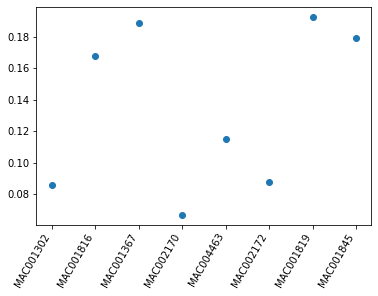

In [ ]:
plt.scatter(x=ids, y=test_mses)
plt.xticks(rotation=60, ha='right')
plt.show()

We can also plot the average MSE per FL rounds.

In [ ]:
mses_per_round = [list() for i in range(9)]
#mapes_per_round = [list() for i in range(20)]

for cl in client_objects:
  for i in range(9):
    mses_per_round[i].append(cl.test_metrics_hist[i])
    #mapes_per_round[i].append(cl.test_metrics_pct_hist[i])

In [ ]:
mse_overall = []
#mape_overall = []

for l in mses_per_round:
  mse_overall.append(np.mean(l))

#for l in mapes_per_round:
#  mape_overall.append(np.mean(l))

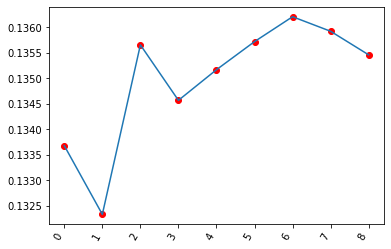

In [ ]:
plt.plot([int(i) for i in range(9)], mse_overall)
plt.scatter([int(i) for i in range(9)], mse_overall, color='r')
plt.xticks(rotation=60, ha='right')
plt.show()

We can now visualize the forecasts to get a better understanding.

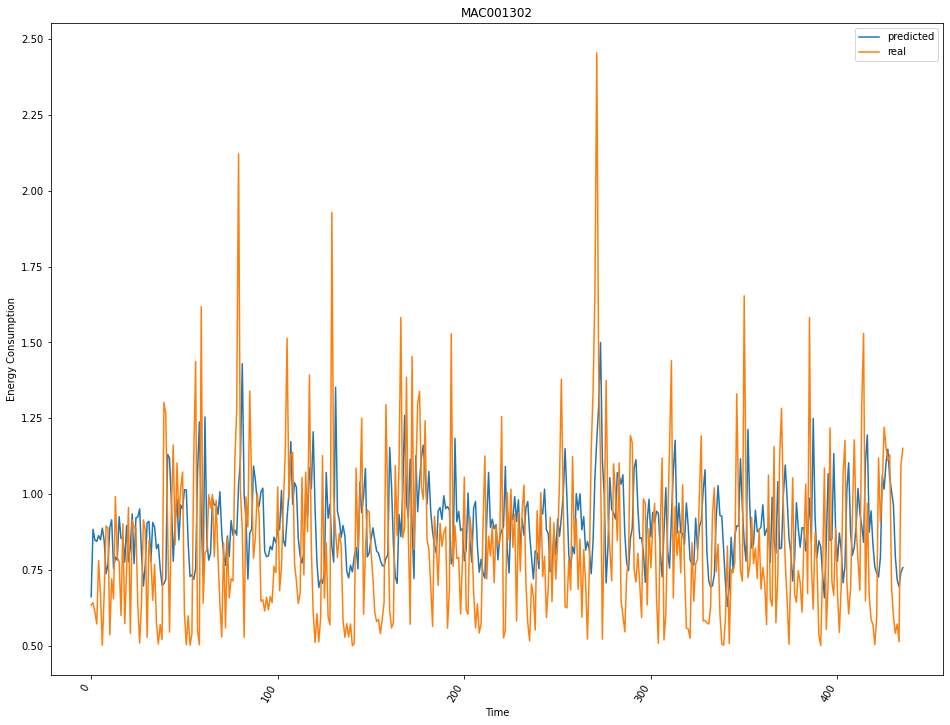

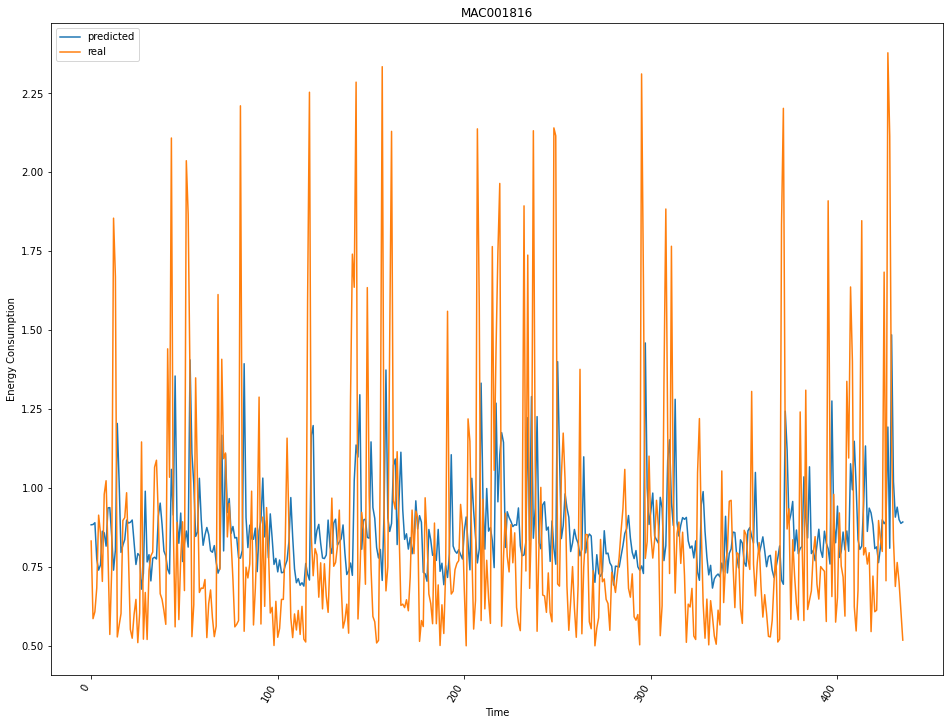

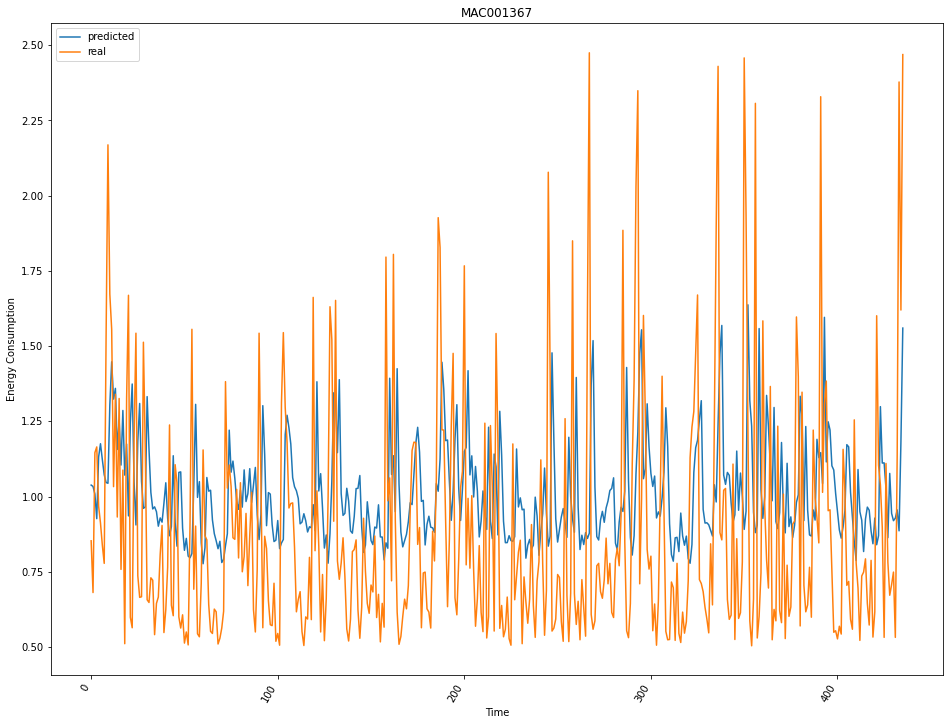

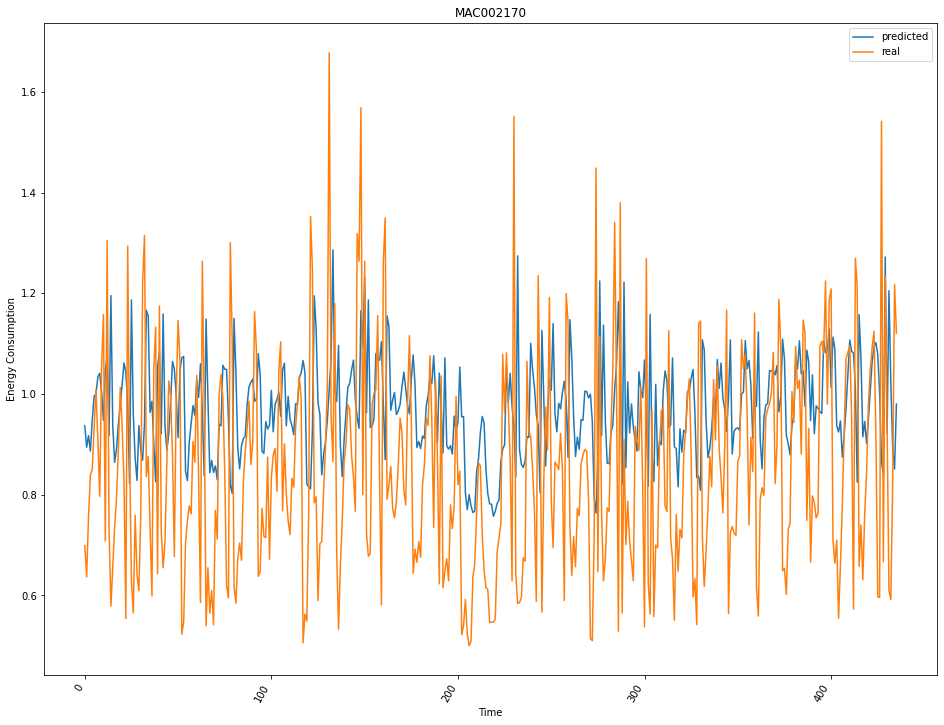

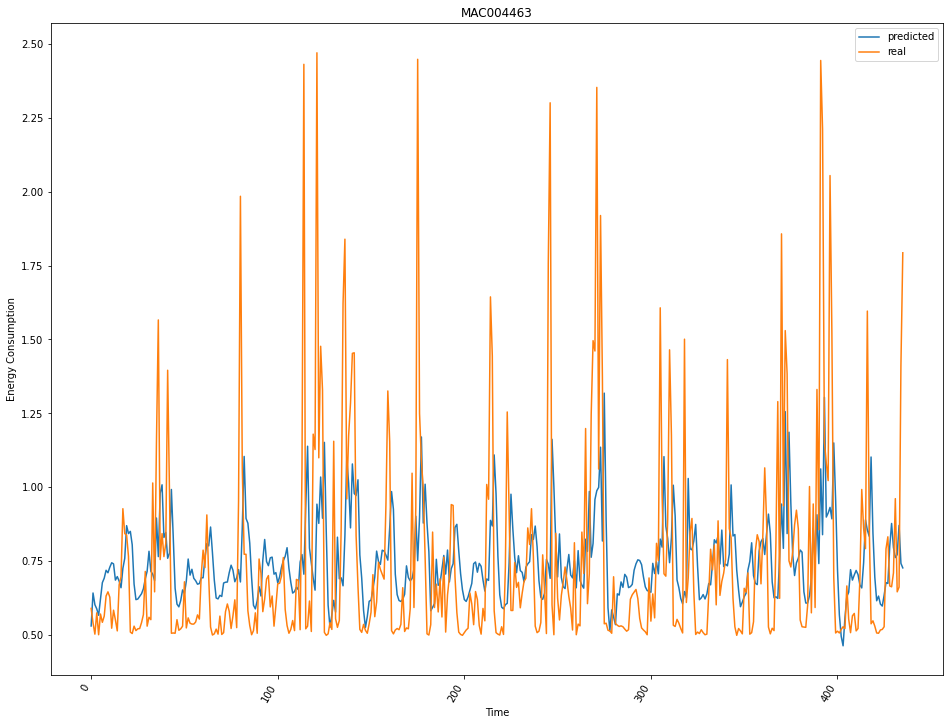

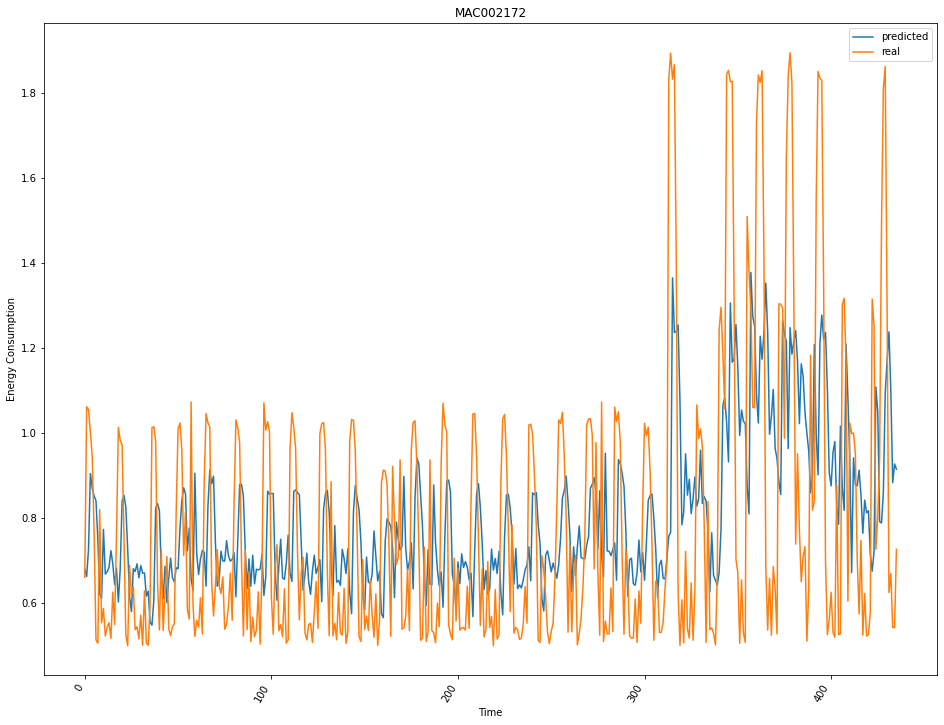

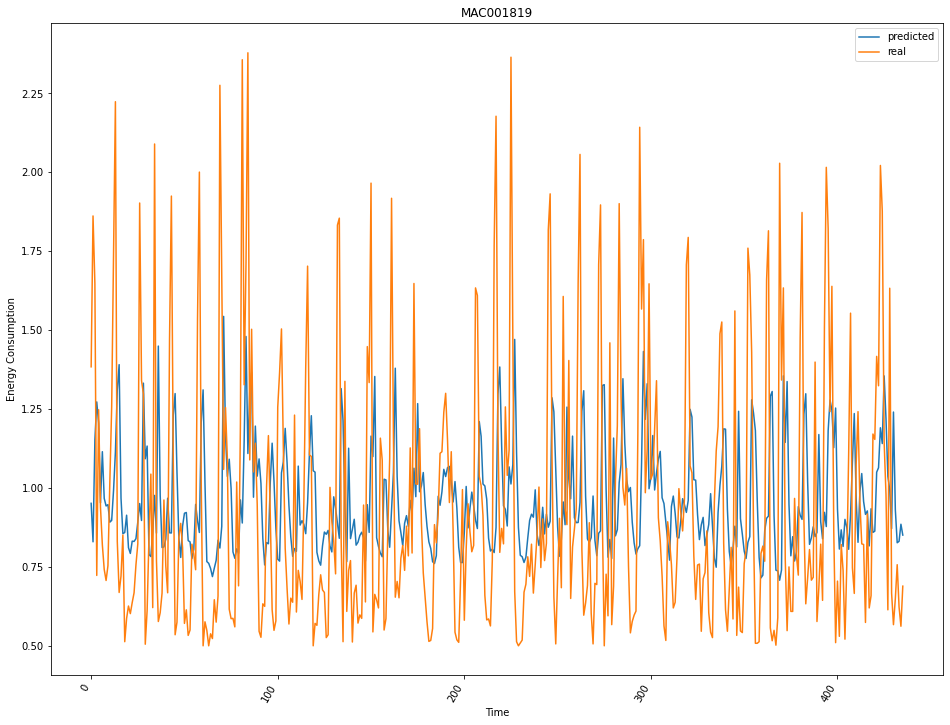

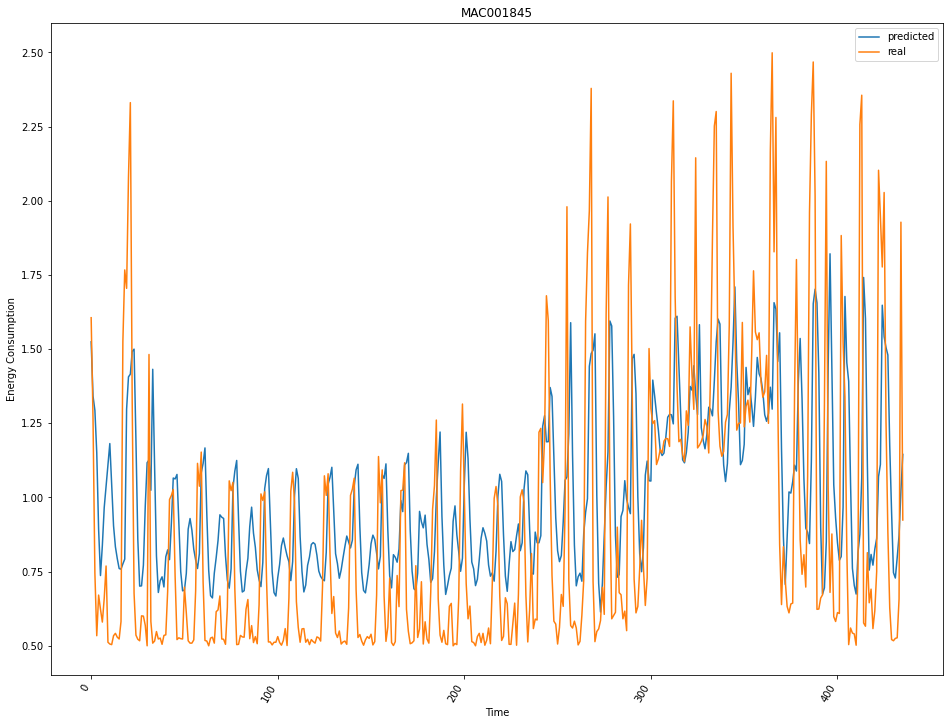

In [ ]:
for cl in client_objects:

  pred = cl.pred_df.iloc[:, target_col_number]
  true = cl.test.iloc[TIME_WINDOW_SIZE:, target_col_number]

  x_ax = list(cl.pred_df.index)
  mpl.rcParams['figure.figsize'] = (16, 12)

  plt.plot(x_ax, pred, label='predicted')
  plt.plot(x_ax, true, label='real')
  plt.xticks(rotation=60, ha='right')
  plt.title(cl.cid)
  plt.ylabel("Energy Consumption")
  plt.xlabel("Time")
  plt.legend()
  plt.show()